In [1]:
import numpy as np
import pandas as pd
from numba import njit
from pandas.api.types import is_datetime64_any_dtype
import time

@njit
def CBS(row):
    """consolidated bid size"""
    col = row.copy() * -1
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]
@njit
def CAS(row):
    """consolidated ask size"""
    col = row.copy()
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]
@njit
def TCBS(cbs):
    """total consolidated bid size"""
    return np.sum(cbs)
@njit
def TCAS(cas):
    """total consolidated ask size"""
    return np.sum(cas)
@njit
def WBP(cbs):
    """weighted bid price"""
    tcbs = TCBS(cbs)
    wbp = 0
    for p, cbsi in enumerate(cbs):
        wbp += (p+1) * (cbsi / tcbs)
    return wbp
@njit
def WAP(cas):
    """weighted bid price"""
    tcas = TCAS(cas)
    wbp = 0
    for p, casi in enumerate(cas):
        wbp += (p+1) * (casi / tcas)
    return wbp
@njit
def AWS(row):
    """actvity weighted spread"""
    return WAP(row) - WBP(row)

def AP(tapes_segment):
    """average price"""
    pass

def AWR(tapes):
    """activity weighted return"""
    pass

@njit
def calculate_high_bid(sliced_arr):
    negative_indices = np.where(sliced_arr < 0, np.arange(sliced_arr.shape[1]), -1)
    max_negative_index = []
    for row in negative_indices:
        max_negative_index.append(max(row))
    max_negative_index.sort()
    high_bid = max_negative_index[len(max_negative_index) // 2] + 1 # get median
    return high_bid

@njit
def calculate_low_ask(sliced_arr):
    positive_indices = np.where(sliced_arr > 0, np.arange(sliced_arr.shape[1]), 800)
    min_positive_index = []
    for row in positive_indices:
        min_positive_index.append(min(row))
    min_positive_index.sort()
    low_ask =  min_positive_index[len(min_positive_index) // 2] + 1 # get median
    return low_ask

def features(day_df, seg_length = "1m", vis=False):

    s = time.time()
    if not is_datetime64_any_dtype(day_df.index):
        print("converting index to datetime")
        day_df.index = pd.to_datetime(day_df.index, unit = "s")
        print(time.time() - s, "taken to convert index")

    segment_length_options = {"1s": int(60*60*8.5), 
                              "5s": int(12*60*8.5), 
                              "10s": int(6*60*8.5),
                              "15s": int(4*60*8.5), 
                              "20s": int(3*60*8.5),
                              "30s": int(2*60*8.5),
                              "1m": int(60*8.5),
                              "2m": int(30*8.5),
                              "5m": int(12*8.5),
                              "10m": int(6*8.5), 
                              "30m": int(2*8.5)}
    
    if seg_length not in segment_length_options.keys():
        raise ValueError("Invalid segment length / step\nPlease pick from "+str(segment_length_options.keys()))
    
    rows = []
    arr = day_df.to_numpy()
    min_time = day_df.index[0]
    max_time = day_df.index[-1]
    start_time = min_time
    length_df = len(day_df)

    cbs_arr = np.zeros((segment_length_options[seg_length],800))
    cas_arr = np.zeros((segment_length_options[seg_length],800))

    i = 0
    start_index = 0
    while start_time < max_time:
        
        end_time = start_time + pd.Timedelta(seg_length)

        end_index = start_index

        while day_df.index[end_index] < end_time and end_index < length_df - 1:
            end_index += 1

        if vis:
            print(start_index, end_index)

        sliced_arr = arr[start_index:end_index]

        row = {"end_time": end_time}

        cbs_arr[i] = np.apply_along_axis(CBS, axis=0, arr = sliced_arr)
        cas_arr[i] = np.apply_along_axis(CAS, axis=0, arr = sliced_arr)
        row["TCBS"] = TCBS(cbs_arr[i])
        row["TCAS"] = TCAS(cas_arr[i])
        row["WBP"] = WBP(cbs_arr[i])
        row["WAP"] = WAP(cas_arr[i])
        row["AWS"] = row["WAP"] - row["WBP"]

        row["high_bid"] = calculate_high_bid(sliced_arr)
        row["low_ask"] = calculate_low_ask(sliced_arr)
        if row["high_bid"] > row["low_ask"]:
            print("bid/ask error,", end_time)

        row["mid_price"] = (row["high_bid"] + row["low_ask"]) / 2
        row["spread"] = row["low_ask"] - row["high_bid"]

        rows.append(row)

        i += 1

        start_time = end_time
        start_index = end_index

        

    out_df = pd.DataFrame(rows)
    out_df.index = out_df["end_time"]
    out_df["WMP"] = (out_df["WBP"] + out_df["WAP"]) / 2
    out_df["TCBS-TCAS"] = out_df["TCBS"] - out_df["TCAS"]
    out_df["TCBS+TCAS"] = out_df["TCBS"] + out_df["TCAS"]

    print(time.time() - s, "time taken to run")

    return out_df.drop(columns=["end_time"], axis = 1), cbs_arr, cas_arr

In [2]:
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)
print("Working directory:", os.getcwd())

from tools import read_csr, get_Tapes
from fast_tools import readc_day, get_dates

dates = get_dates()

data = readc_day(dates[0])

tapes_data = get_Tapes(0)[0]

os.chdir(current_directory)
print("Working directory:", os.getcwd())

Working directory: c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19
Opening UoB_Set01_2025-01-02tapes.csv
Working directory: c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\Data Processing


In [3]:
lob_data = pd.DataFrame(data[0])
lob_data.index = data[1]
lob_data

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0.000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.279,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.333,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.581,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1.643,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30599.542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30599.573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30599.635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30599.759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
min_df, cbs_arr, cas_arr = features(lob_data, seg_length="5s")
min_df

converting index to datetime
0.19213438034057617 taken to convert index
51.53561735153198 time taken to run


,TCBS,TCAS,WBP,WAP,AWS,high_bid,low_ask,mid_price,spread,WMP,TCBS-TCAS,TCBS+TCAS
end_time,,,,,,,,,,,,
1970-01-01 00:00:05,43.0,80.0,189.697674,353.900000,164.202326,262,296,279.0,34,271.798837,-37.0,123.0
1970-01-01 00:00:10,70.0,161.0,245.600000,284.018634,38.418634,266,278,272.0,12,264.809317,-91.0,231.0
1970-01-01 00:00:15,165.0,176.0,138.890909,329.653409,190.762500,267,270,268.5,3,234.272159,-11.0,341.0
1970-01-01 00:00:20,229.0,171.0,187.349345,400.935673,213.586328,265,268,266.5,3,294.142509,58.0,400.0
1970-01-01 00:00:25,551.0,259.0,224.003630,443.567568,219.563938,263,273,268.0,10,333.785599,292.0,810.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 08:29:40,536.0,196.0,206.194030,497.117347,290.923317,287,291,289.0,4,351.655688,340.0,732.0
1970-01-01 08:29:45,274.0,114.0,219.255474,472.289474,253.033999,287,291,289.0,4,345.772474,160.0,388.0
1970-01-01 08:29:50,332.0,183.0,235.162651,477.065574,241.902923,290,294,292.0,4,356.114112,149.0,515.0


264 324


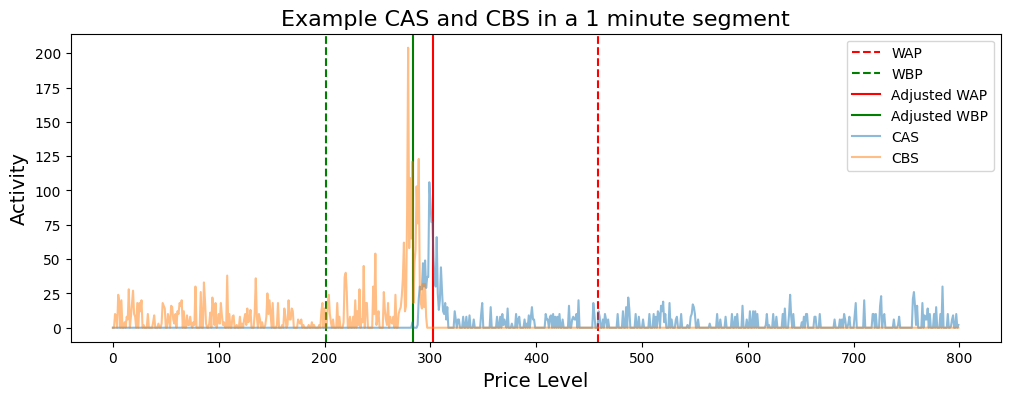

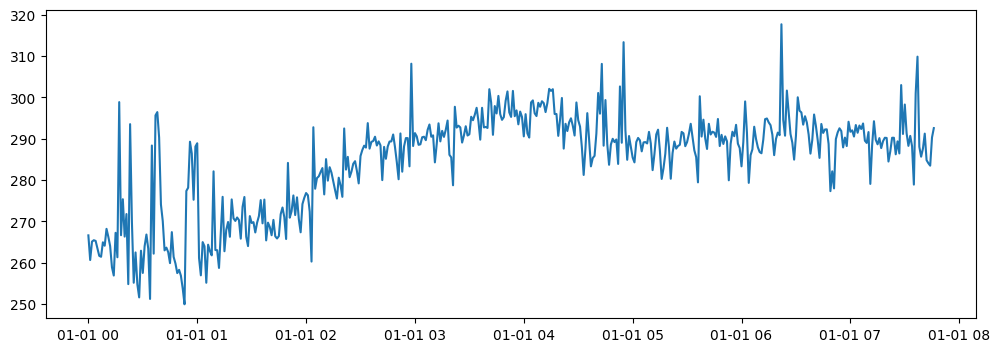

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Creating DataFrames
cas_df = pd.DataFrame(cas_arr, index=min_df.index)
cbs_df = pd.DataFrame(cbs_arr, index=min_df.index)

# Resampling DataFrames
cas_df = cas_df.resample("1min").sum()
cbs_df = cbs_df.resample("1min").sum()
mp_df = min_df.resample("1min").mean()

# Plotting
n = np.random.randint(len(cas_df))

MP = mp_df.iloc[n]["mid_price"]
plt.figure(figsize=(12, 4))


# Adding vertical lines
plt.axvline(WAP(cas_df.iloc[n].to_numpy()), label="WAP", color='r', linestyle = "--")
plt.axvline(WBP(cbs_df.iloc[n].to_numpy()), label="WBP", color='g', linestyle = "--")

# Adjusted vertical lines
min_price = int(MP - 30)
max_price = int(MP + 30)
print(min_price, max_price)
plt.axvline(min_price + WAP(cas_df.iloc[n].to_numpy()[min_price:max_price]), label="Adjusted WAP", color='r')
plt.axvline(min_price + WBP(cbs_df.iloc[n].to_numpy()[min_price:max_price]), label="Adjusted WBP", color='g')
#plt.axvline(MP, label="MP", color='black')

# Title and axis labels
plt.title("Example CAS and CBS in a 1 minute segment", fontsize = 16)
plt.xlabel("Price Level", fontsize = 14)
plt.ylabel("Activity", fontsize = 14)

plt.plot(cas_df.iloc[n], label="CAS", alpha = 0.5)
plt.plot(cbs_df.iloc[n], label="CBS", alpha = 0.5)

plt.legend()
plt.show()

plt.figure(figsize = (12,4))
plt.plot(mp_df["mid_price"].iloc[:n])


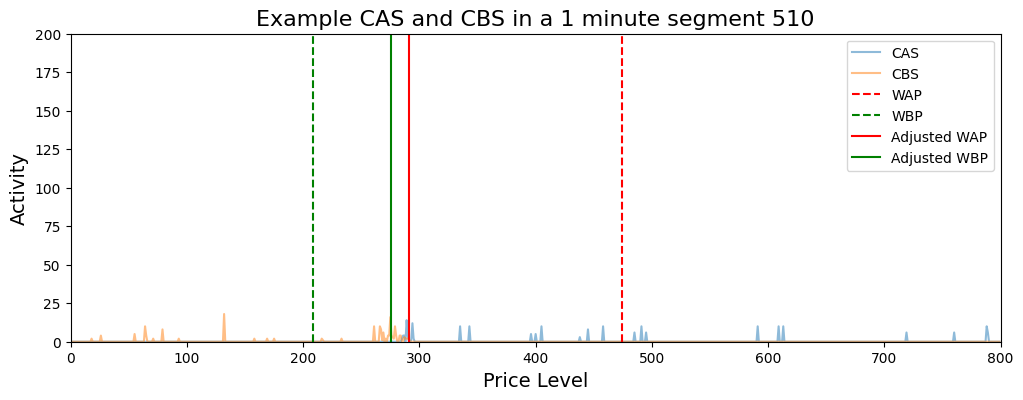

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming you have defined the WAP and WBP functions elsewhere

# Creating DataFrames
cas_df = pd.DataFrame(cas_arr, index=min_df.index)
cbs_df = pd.DataFrame(cbs_arr, index=min_df.index)

# Resampling DataFrames
cas_df = cas_df.resample("1min").sum()
cbs_df = cbs_df.resample("1min").sum()

min_min_df = min_df.resample("1min").mean()

fig, ax = plt.subplots(figsize=(12, 4))

def animate(n):
    print(n, end = "\r")
    ax.clear()
    MP = min_min_df.iloc[n]["mid_price"]
    ax.plot(cas_df.iloc[n], label="CAS", alpha=0.5)
    ax.plot(cbs_df.iloc[n], label="CBS", alpha=0.5)

    ax.axvline(WAP(cas_df.iloc[n].to_numpy()), label="WAP", color='r', linestyle="--")
    ax.axvline(WBP(cbs_df.iloc[n].to_numpy()), label="WBP", color='g', linestyle="--")

    min_price = int(MP - 40)
    max_price = int(MP + 40)
    ax.axvline(min_price + WAP(cas_df.iloc[n].to_numpy()[min_price:max_price]), label="Adjusted WAP", color='r')
    ax.axvline(min_price + WBP(cbs_df.iloc[n].to_numpy()[min_price:max_price]), label="Adjusted WBP", color='g')

    ax.set_title(f"Example CAS and CBS in a 1 minute segment {n}", fontsize=16)
    ax.set_xlabel("Price Level", fontsize=14)
    ax.set_ylabel("Activity", fontsize=14)

    ax.set_ylim(0, 200)
    ax.set_xlim(0, 800)

    ax.legend()

ani = FuncAnimation(fig, animate, frames=len(cas_df), interval=100)
ani.save('animation.gif', writer='pillow', fps=10)

plt.show()
